## Convolutional Neural Networks (with Pytorch)
This is the epitome of what the project has been working towards. I've mostly been working with classical models, to get a feel for a workflow, and throughout the process we realized that they are definitely not suited for this type of data. CNN's are better at capturing features within an image and they use the feature maps in the fully-connected network to predict the target. <br>
I'll be testing a few architectures.
- basic architecture that does well
- super light/small architecture
- my best tuned/get highest test accuracy architecture

The loss function I'll use for every model is cross entropy loss. This is the standard for classification models. In my notebook I talk about how it can be skewed depending on the probability distribution of the dataset, but that is a digression. The optimizer for all models as well is Adam (adaptive moment estimation). I read the paper on this optimizing algorithm and for the most part it went over my head. The general gist of it is that it essentially uses SGD but can dynamically adjust learning rate on a per parameter basis. Making it basically the best go to optimizer. 

### Cifar10NN
The model has: 3 Convolutional layers, 4 Fully-Connected layers<br>
it uses a dropout of 25% and MaxPooling.

*Training*
The model was trained on Tenochtitlan and was quick, 10 epochs took ~48s. Also without even really tuning or anything it ended up with scores of:<br>
`Train Accuracy: 76.99%` <br>
`Test Accuracy: 69.73%`<br>
Which blows all the classical models away (as expected). It's a tad overfit, due to a train accuracy being 7% higher, but not anything radical. I also plotted the loss since that seems like an important metric to keep track of, it's noisy but downward trends beautifully. It almost seems to be a decreasing exponential graph.

ChatGPT basically helped me set up 85%+ but hey I'm the one that pushed the button! I want to get better at just knowing what python code to write, but I also don't want to get too bogged down with memorizing notation/syntax. Start with at least being able to understand the bigger picture and drill down from there.



In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import pandas as pd

import seaborn as sns
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [2]:
# some vars
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define transformations for dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Explore the data
print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))

example_image, example_label = train_dataset[0]
print("Image shape:", example_image.shape)

# Get the number of classes
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Training dataset size: 50000
Testing dataset size: 10000
Image shape: torch.Size([3, 32, 32])
Number of classes: 10


## 1. Basic Architecture

In [18]:
# defining nn architecture
class Cifar10NN(nn.Module):
    def __init__(self):
        super(Cifar10NN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  #the layer produces 32 output feature maps (each is a result of convolving the input with a different kernel/filter).
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for the output size after pooling
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))            # after this max pooling, the tensor shape becomes (batch_size, 32, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))            # now (batch_size, 64, 8, 8)
        x = self.pool(F.relu(self.conv3(x)))            # now (batch_size, 128, 4, 4)

        # Flatten the output for the fully connected layers, 1-D
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

In [6]:
# instantiate model, move it to gpu (if available)
model = Cifar10NN()
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

Cifar10NN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [7]:
# training loop
num_epochs = 10
training_losses = [] 
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Track the loss for each epoch

    for i, data in enumerate(train_loader, 0):
        # 1. get a batch of data
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 2. reset gradients (aside from first iteration, these have some value)
        optimizer.zero_grad()

        # 3. run the data through the model. forward pass
        y_pred = model(inputs)

        # 4. Compute the loss
        loss = cost(y_pred, labels)

        # 5. Backpropagation
        loss.backward()

        # 6. update weights
        optimizer.step()

        training_losses.append(loss.item())
        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0


end_time = time.time() 
total_training_time = end_time - start_time  # Calculate total training time

print(f'Done. Total Training Time: {total_training_time:.2f}s')

Epoch 1, Batch 100, Loss: 2.273
Epoch 1, Batch 200, Loss: 2.045
Epoch 1, Batch 300, Loss: 1.850
Epoch 1, Batch 400, Loss: 1.744
Epoch 1, Batch 500, Loss: 1.681
Epoch 1, Batch 600, Loss: 1.604
Epoch 1, Batch 700, Loss: 1.594
Epoch 2, Batch 100, Loss: 1.483
Epoch 2, Batch 200, Loss: 1.464
Epoch 2, Batch 300, Loss: 1.415
Epoch 2, Batch 400, Loss: 1.422
Epoch 2, Batch 500, Loss: 1.367
Epoch 2, Batch 600, Loss: 1.350
Epoch 2, Batch 700, Loss: 1.324
Epoch 3, Batch 100, Loss: 1.262
Epoch 3, Batch 200, Loss: 1.243
Epoch 3, Batch 300, Loss: 1.213
Epoch 3, Batch 400, Loss: 1.210
Epoch 3, Batch 500, Loss: 1.208
Epoch 3, Batch 600, Loss: 1.169
Epoch 3, Batch 700, Loss: 1.162
Epoch 4, Batch 100, Loss: 1.136
Epoch 4, Batch 200, Loss: 1.106
Epoch 4, Batch 300, Loss: 1.073
Epoch 4, Batch 400, Loss: 1.070
Epoch 4, Batch 500, Loss: 1.067
Epoch 4, Batch 600, Loss: 1.083
Epoch 4, Batch 700, Loss: 1.089
Epoch 5, Batch 100, Loss: 1.013
Epoch 5, Batch 200, Loss: 0.976
Epoch 5, Batch 300, Loss: 0.982
Epoch 5,

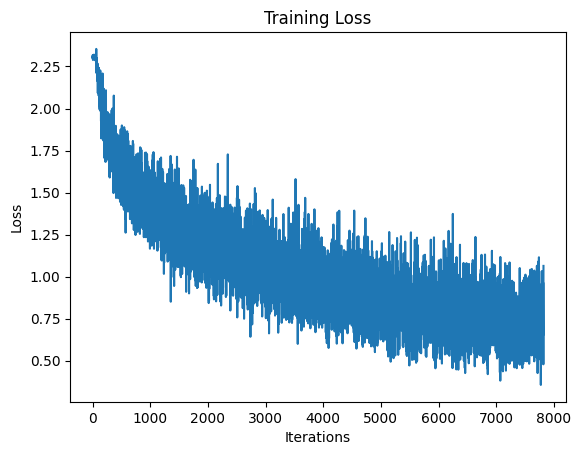

In [19]:
# loss plot
df_loss = pd.DataFrame({'iteration': range(1, len(training_losses) + 1), 'loss': training_losses})
sns.lineplot(df_loss, x='iteration', y='loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [17]:
# evaluate model
def evaluate(data_loader):
    correct = 0
    total = 0
    with torch.inference_mode():  # Ensures inference mode is active
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

print(f"Train Accuracy: {evaluate(train_loader):.2f}%")    
print(f"Test Accuracy: {evaluate(test_loader):.2f}%")    

Train Accuracy: 76.99%
Test Accuracy: 69.73%


## 2. Lightweight/Small Architecture

In [ ]:
class SmallCifar10NN(nn.Module):
    def __init__(self):
        super(SmallCifar10NN, self).__init__()

        # 2 convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # global average pooling (GAP) intead of fc layers
        self.global_pool = nn.AdaptiveAvgPool2d(1)